In [ ]:
## Notebook env: old_cell2loc_env (old_cell2loc_env kernel)
## this notebook performs cell2location to *spatially* deconvolute cells using a reference annotated scRNAseq dataset

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import gc

# if using the CPU uncomment this:
os.environ["THEANO_FLAGS"] = 'device=cpu,floatX=float32,openmp=False,force_device=True'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import mmread

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

In [2]:
# Set paths to data and results used through the document:
sp_data_folder = '/home/ssobti/projects/farnaz_spatial/data/monkey_data/unpacked_data/'
results_folder = '/home/ssobti/projects/farnaz_spatial/output_data/monkey/cell2location/old_cell2location_multi_ref_annot/'
nb_mtx_path = '/home/ssobti/projects/farnaz_spatial/output_data/monkey/UMI_normalized_seurat_slices/'

regression_model_output = 'RegressionGeneBackgroundCoverageTorch_22covariates_291834cells_13082genes'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'

## 1. Loading Visium Data

In [3]:
def read_and_qc(sample_name, path=sp_data_folder, norm_mtx_path = nb_mtx_path):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name) + '/outs',
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var_names_make_unique()
    genes = pd.read_csv(nb_mtx_path + 'seurat_' + sample_name + '_neg_binomial_counts_genes.csv')['x'].values
    spots = pd.read_csv(nb_mtx_path + 'seurat_' + sample_name + '_neg_binomial_counts_cells.csv')['x'].values
    genes_to_correct = list(set(genes).difference(set(adata.var_names)).intersection(set(genes)))
    genes = [s[:-2] + '-1' if s in genes_to_correct and s.endswith('.1') else s for s in genes]
    adata = adata[spots, genes]
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    from scipy.sparse import csr_matrix
    sc.pp.calculate_qc_metrics(adata, inplace=True)

    mtx = csr_matrix(mmread(nb_mtx_path + 'seurat_' + sample_name + '_neg_binomial_counts.mtx').T)
    adata.X = mtx
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

#######################
# Read the list of spatial experiments
sample_data = pd.read_csv(sp_data_folder + 'visium.csv')

# Read the data into anndata objects
slides = []
for i in sample_data['sample_name']:
    slides.append(read_and_qc(i, path=sp_data_folder))

#### change the slide identity key in .uns so they aren't the repeats between slides ####
## new names:
## 096-count-A1: 1149_G
## 096-count-D1: 1572_G
## 327-count-A1: 1080_T
## 327-count-D1: 1080_B

slides[0].uns['spatial']['1149G_A1_096'] = slides[0].uns['spatial'].pop('count-A1')
slides[1].uns['spatial']['1572G_D1_096'] = slides[1].uns['spatial'].pop('count-D1')
slides[2].uns['spatial']['1080T_A1_327'] = slides[2].uns['spatial'].pop('count-A1')
slides[3].uns['spatial']['1080B_D1_327'] = slides[3].uns['spatial'].pop('count-D1')
#######################

# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'],
    index_unique=None
)

In [4]:
# mitochondria-encoded (MT) genes should be removed for spatial mapping
adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
adata = adata[:, ~adata.var['mt'].values]

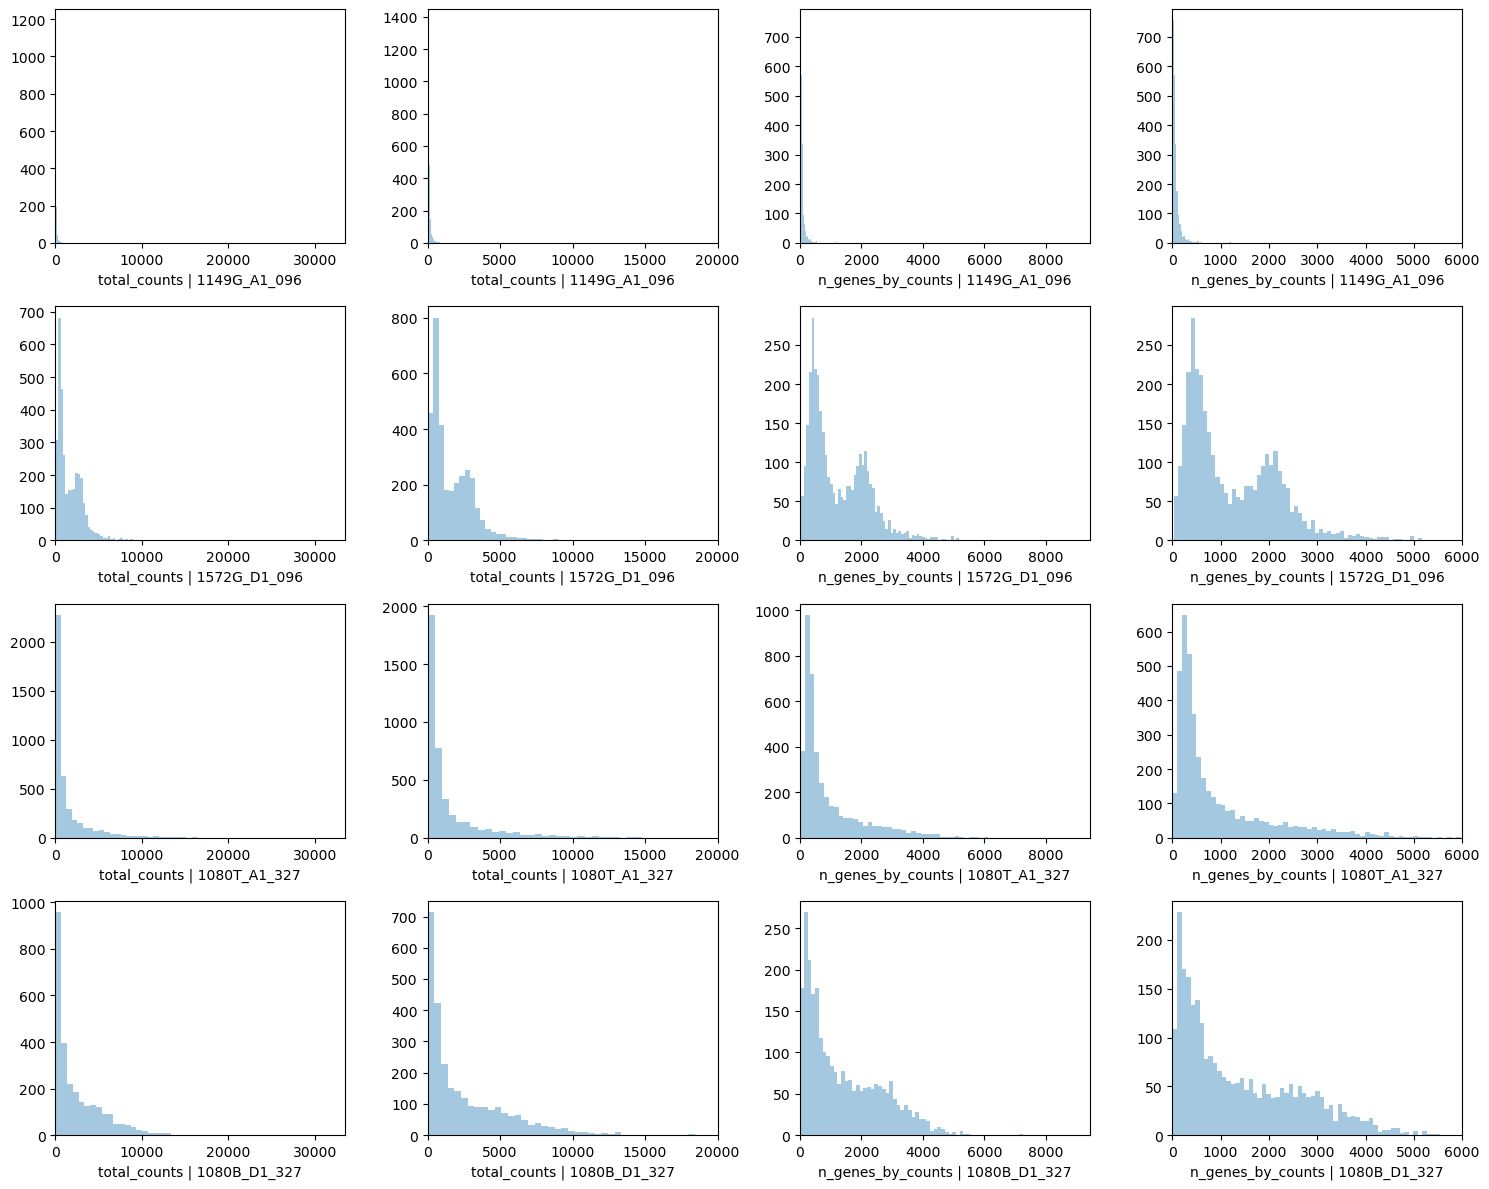

In [5]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i, s in enumerate(adata.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')

    slide = select_slide(adata, s)
    sns.distplot(slide.obs['total_counts'],
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

## 2. Visualise Visium data in spatial 2D and UMAP coordinates

In [6]:
slide.var

,feature_types,genome,SYMBOL,mt,n_cells_by_counts-1080B_D1_327,mean_counts-1080B_D1_327,log1p_mean_counts-1080B_D1_327,pct_dropout_by_counts-1080B_D1_327,total_counts-1080B_D1_327,log1p_total_counts-1080B_D1_327,...,log1p_mean_counts-1149G_A1_096,pct_dropout_by_counts-1149G_A1_096,total_counts-1149G_A1_096,log1p_total_counts-1149G_A1_096,n_cells_by_counts-1572G_D1_096,mean_counts-1572G_D1_096,log1p_mean_counts-1572G_D1_096,pct_dropout_by_counts-1572G_D1_096,total_counts-1572G_D1_096,log1p_total_counts-1572G_D1_096
ENSEMBL,,,,,,,,,,,,,,,,,,,,,
ENSG00000187634,Gene Expression,GRCh38,SAMD11,False,105,0.041590,0.040748,96.135444,113.0,4.736198,...,0.003692,99.768840,8.0,2.197225,119,0.038473,0.037751,96.423204,128.0,4.859812
ENSG00000187961,Gene Expression,GRCh38,KLHL17,False,104,0.040118,0.039334,96.172249,109.0,4.700480,...,0.006911,99.352751,15.0,2.772589,177,0.055906,0.054399,94.679892,186.0,5.231109
ENSG00000188290,Gene Expression,GRCh38,HES4,False,373,0.181082,0.166431,86.271623,492.0,6.200509,...,0.014686,98.844198,32.0,3.496508,321,0.111812,0.105992,90.351668,372.0,5.921578
ENSG00000188157,Gene Expression,GRCh38,AGRN,False,172,0.070298,0.067937,93.669488,191.0,5.257495,...,0.009662,99.214055,21.0,3.091043,224,0.076646,0.073850,93.267208,255.0,5.545177
ENSG00000186891,Gene Expression,GRCh38,TNFRSF18,False,36,0.013618,0.013526,98.675009,37.0,3.637586,...,0.005073,99.630143,11.0,2.484907,174,0.057409,0.055822,94.770063,191.0,5.257495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000185515,Gene Expression,GRCh38,BRCC3,False,489,0.240339,0.215384,82.002208,653.0,6.483108,...,0.006452,99.537679,14.0,2.708050,410,0.138563,0.129767,87.676586,461.0,6.135565
ENSG00000155959,Gene Expression,GRCh38,VBP1,False,314,0.137652,0.128966,88.443136,374.0,5.926926,...,0.003692,99.630143,8.0,2.197225,178,0.057409,0.055822,94.649835,191.0,5.257495
ENSG00000155962,Gene Expression,GRCh38,CLIC2,False,219,0.087597,0.083970,91.939639,238.0,5.476463,...,0.003692,99.676375,8.0,2.197225,431,0.152089,0.141577,87.045386,506.0,6.228511


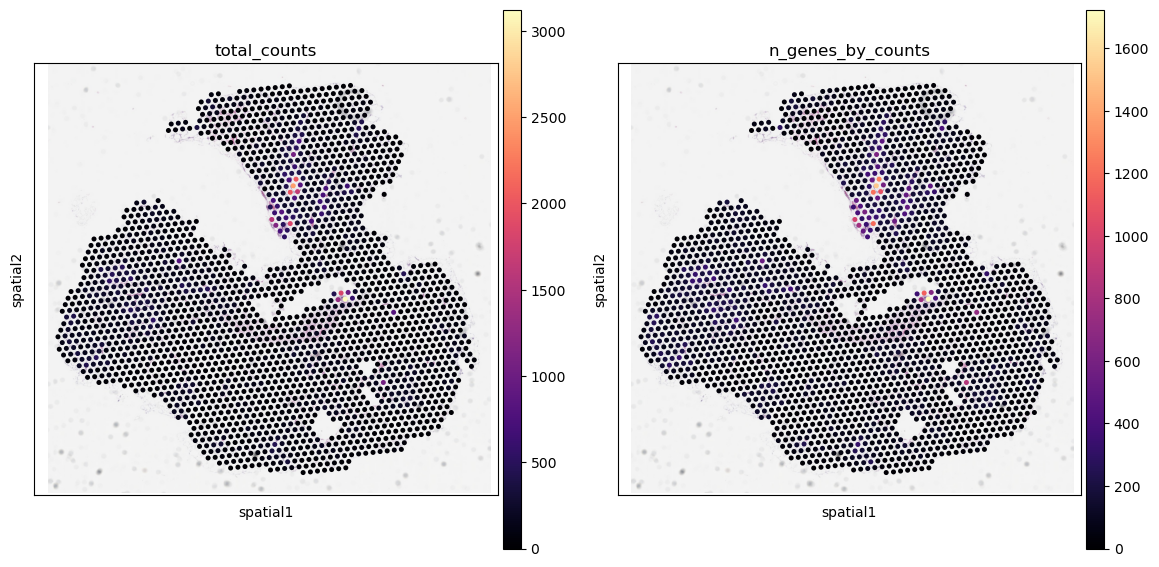

In [7]:
slide = select_slide(adata, '1149G_A1_096')

with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'white'}):
    sc.pl.spatial(slide, img_key = "hires", cmap='magma',
                  library_id=list(slide.uns['spatial'].keys())[0],
                  color=['total_counts', 'n_genes_by_counts'], size=1,
                  gene_symbols='SYMBOL', show=False, return_fig=True)

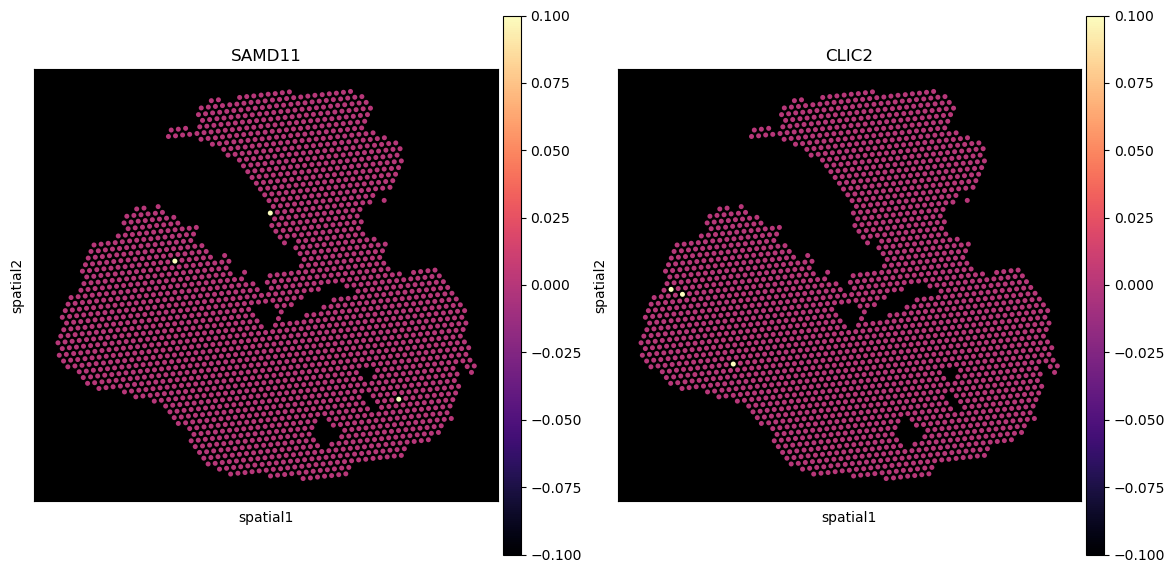

In [8]:
with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'black'}):
    sc.pl.spatial(slide,
                  color=["SAMD11", "CLIC2"], img_key=None, size=1,  ##### FIXX !!!! with relevant genes?? #####
                  vmin=0, cmap='magma', vmax='p99.0',
                  gene_symbols='SYMBOL'
                 )

In [9]:
adata_vis = adata.copy()
adata_vis.raw = adata_vis

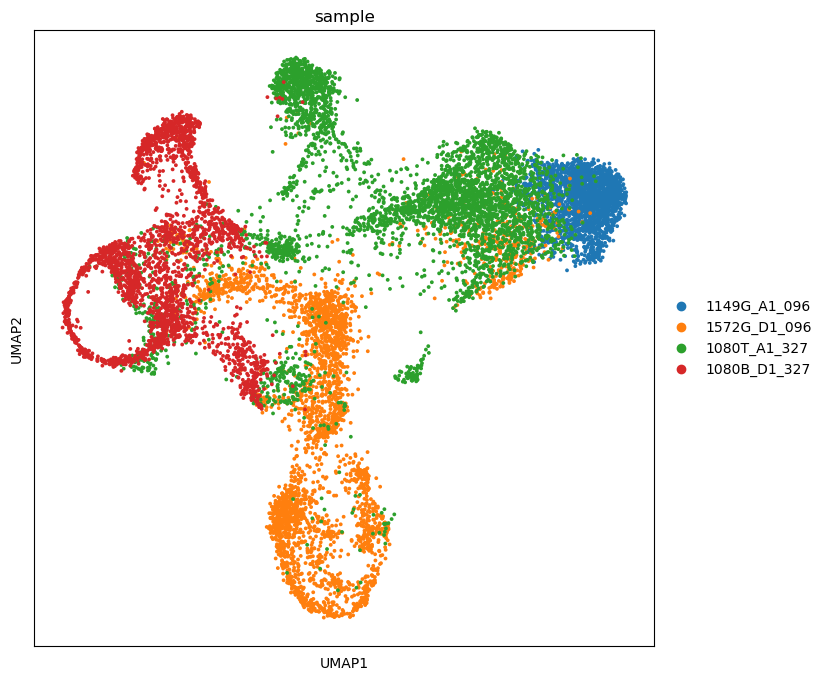

In [10]:
adata_vis_plt = adata_vis.copy()

# Log-transform (log(data + 1))
sc.pp.log1p(adata_vis_plt)

# Find highly variable genes within each sample
adata_vis_plt.var['highly_variable'] = False
for s in adata_vis_plt.obs['sample'].unique():

    adata_vis_plt_1 = adata_vis_plt[adata_vis_plt.obs['sample'].isin([s]), :]
    sc.pp.highly_variable_genes(adata_vis_plt_1, min_mean=0.0125, max_mean=5, min_disp=0.5, n_top_genes=1000)

    hvg_list = list(adata_vis_plt_1.var_names[adata_vis_plt_1.var['highly_variable']])
    adata_vis_plt.var.loc[hvg_list, 'highly_variable'] = True

# Scale the data ( (data - mean) / sd )
sc.pp.scale(adata_vis_plt, max_value=10)
# PCA, KNN construction, UMAP
sc.tl.pca(adata_vis_plt, svd_solver='arpack', n_comps=40, use_highly_variable=True)
sc.pp.neighbors(adata_vis_plt, n_neighbors = 20, n_pcs = 40, metric='cosine')
sc.tl.umap(adata_vis_plt, min_dist = 0.3, spread = 1)

with mpl.rc_context({'figure.figsize': [8, 8],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_vis_plt, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 1, #legend_loc='on data',
               legend_fontsize=10)

## 3. Load reference cell type signature from snRNA-seq data and show UMAP of cells

In [11]:
## snRNAseq reference (raw counts)
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')

In [12]:
## load in converted reference mouse gene names to human
m2h_genes_output = pd.read_csv(results_folder + 'm2h_genes.csv')
m2h_genes_output = m2h_genes_output['0'].to_list()

In [13]:
## convert names
adata_snrna_raw.var.index = m2h_genes_output
adata_snrna_raw.var['features'] = m2h_genes_output
adata_snrna_raw.var['SYMBOL'] = m2h_genes_output

In [14]:
adata_snrna_raw.var

,features,SYMBOL,n_cells,nonz_mean,mean,std
XKR4,XKR4,XKR4,28845,3.544358,0.123566,0.422929
SOX17,SOX17,SOX17,5268,3.390471,0.022298,0.184459
MRPL15,MRPL15,MRPL15,33361,1.288750,0.090257,0.264019
LYPLA1,LYPLA1,LYPLA1,22573,1.209365,0.059409,0.212534
TCEA1,TCEA1,TCEA1,43665,1.321287,0.120740,0.302446
...,...,...,...,...,...,...
CCR8,CCR8,CCR8,160,1.175000,0.000413,0.018196
CCDC152,CCDC152,CCDC152,20319,3.230031,0.081464,0.342263
FBXO40,FBXO40,FBXO40,1035,1.228986,0.002726,0.047587
EXTL1,EXTL1,EXTL1,1700,1.218824,0.004494,0.060707


In [15]:
# Column name containing cell type annotations
covariate_col_names = 'annotation_1'

# Extract a pd.DataFrame with signatures from anndata object
inf_aver = adata_snrna_raw.raw.var.copy()
inf_aver = inf_aver.loc[:, [f'means_cov_effect_{covariate_col_names}_{i}' for i in adata_snrna_raw.obs[covariate_col_names].unique()]]
from re import sub
inf_aver.columns = [sub(f'means_cov_effect_{covariate_col_names}_{i}', '', i) for i in adata_snrna_raw.obs[covariate_col_names].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# normalise by average experiment scaling factor (corrects for sequencing depth)
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

## convert names to human
inf_aver.index = m2h_genes_output

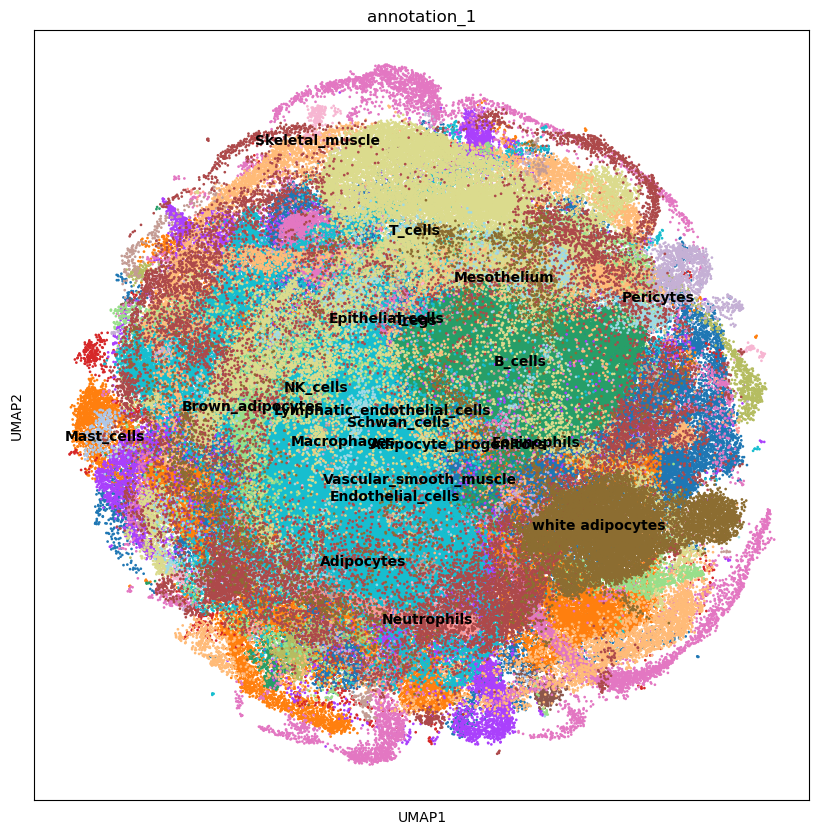

In [16]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw, color=['annotation_1'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)

In [17]:
# now we don't need to keep the scRNA-seq data set and a list with slides in memory
del adata_snrna_raw, slides
gc.collect()

35918

## 4. Cell2location model description and analysis pipeline

In [18]:
## make symbols var names instead of ENSEMBL IDs
adata_vis.var.index = adata_vis.var['SYMBOL']
intersected_genes = set(adata_vis.var['SYMBOL']).intersection(set(inf_aver.index))
adata_vis.var_names_make_unique()

In [19]:
## intersect genes
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()

inf_aver_copy = inf_aver.copy() ## infer_aver has non-unique rownames -- fix
inf_aver_copy['genes'] = inf_aver_copy.index
inf_aver_copy = inf_aver_copy.groupby('genes').mean().reset_index() ## average expression of genes with non-unique symbols
inf_aver_copy.index = inf_aver_copy['genes'] 
inf_aver_copy.index.name = None
inf_aver_copy = inf_aver_copy.drop(columns=['genes'])
inf_aver = inf_aver_copy.loc[intersect, :].copy()  

In [20]:
## load in nuclei DAPI counts
nuclei_counts_1149G = pd.read_csv('/home/ssobti/projects/farnaz_spatial/data/monkey_data/DAPI_nuclei_counts/1149G_results.csv')

## remove first row which is total counts and reset index
nuclei_counts_1149G = nuclei_counts_1149G.iloc[1:, :].reset_index(drop=True)

## turn all 1s into 0s due to blackspace in images

In [21]:
nuclei_counts_1149G

,Slice,Count,Total Area,Average Size,%Area,Perim.
0,1149G_A1_096_DAPI_overlaid.tif,1,2325.917,2325.917,100.000,179.205
1,1149G_A1_096_DAPI_overlaid.tif,1,2325.917,2325.917,100.000,179.205
2,1149G_A1_096_DAPI_overlaid.tif,1,2325.917,2325.917,100.000,179.205
3,1149G_A1_096_DAPI_overlaid.tif,1,2325.917,2325.917,100.000,179.205
4,1149G_A1_096_DAPI_overlaid.tif,1,2325.917,2325.917,100.000,179.205
...,...,...,...,...,...,...
9979,1149G_A1_096_DAPI_overlaid.tif,0,0.000,NaN,0.000,NaN
9980,1149G_A1_096_DAPI_overlaid.tif,0,0.000,NaN,0.000,NaN
9981,1149G_A1_096_DAPI_overlaid.tif,1,2075.324,2075.324,89.226,171.828
9982,1149G_A1_096_DAPI_overlaid.tif,1,2325.917,2325.917,100.000,179.205


In [23]:
sc.settings.set_figure_params(dpi = 100, color_map = 'viridis', dpi_save = 100,
                              vector_friendly = True, format = 'pdf',
                              facecolor='white')

r = cell2location.run_cell2location(

      # Single cell reference signatures as pd.DataFrame
      # (could also be data as anndata object for estimating signatures
      #  as cluster average expression - `sc_data=adata_snrna_raw`)
      sc_data=inf_aver,
      # Spatial data as anndata object
      sp_data=adata_vis,

      # the column in sc_data.obs that gives cluster idenitity of each cell
      summ_sc_data_args={'cluster_col': "annotation_1",
                        },

      train_args={'use_raw': False, # By default uses raw slots in both of the input datasets.
                  'n_iter': 40000, # Increase the number of iterations if needed (see QC below)

                  # Whe analysing the data that contains multiple experiments,
                  # cell2location automatically enters the mode which pools information across experiments
                  'sample_name_col': 'sample'}, # Column in sp_data.obs with experiment ID (see above)


      export_args={'path': results_folder, # path where to save results
                   'save_model': True,
                   'run_name_suffix': '' # optinal suffix to modify the name the run
                  },

      model_kwargs={ # Prior on the number of cells, cell types and co-located groups

                    'cell_number_prior': {
                        # - N - the expected number of cells per location:
                        'cells_per_spot': 2, #nuclei_count_mtx < - change this ### first try one slide with row x column np.array, then provide *list* of arrays for slides
                        # - A - the expected number of cell types per location (use default):
                        'factors_per_spot': 7,
                        # - Y - the expected number of co-located cell type groups per location (use default):
                        'combs_per_spot': 7
                    },

                     # Prior beliefs on the sensitivity of spatial technology:
                    'gene_level_prior':{
                        # Prior on the mean
                        'mean': 1/2,
                        # Prior on standard deviation,
                        # a good choice of this value should be at least 2 times lower that the mean
                        'sd': 1/4
                    }
      }
)

### Summarising single cell clusters ###
### Creating model ### - time 0.24 min


KeyboardInterrupt: 

In [ ]:
results_folder + r['run_name']

In [ ]:
## r = {'run_name': 'LocationModelLinearDependentWMultiExperiment_2experiments_59clusters_5563locations_12809genes'}

In [ ]:
from IPython.display import Image
Image(filename=results_folder +r['run_name']+'/plots/training_history_without_first_20perc.png',
      width=400)

In [ ]:
Image(filename=results_folder +r['run_name']+'/plots/data_vs_posterior_mean.png',
      width=400)

In [ ]:
Image(filename=results_folder +r['run_name']+'/plots/evaluate_stability.png',
      width=400)